<a href="https://colab.research.google.com/github/yahyazuher/AI-Liver-Disease-Diagnosis-System/blob/main/notebooks/AI_Liver_Diseases_Diagnosis_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  AI Multi-Model System for Liver Disease Diagnosis and Risk Assessment
##  Full System Model Inspector
---
**Author:** Yahya Zuher

**GitHub:** yahyazuher


# ALL serialized ML models Columns

In [ ]:
"""
Description:
    This script automatically downloads ALL serialized machine learning models
    from the AiLDS GitHub repository (including Cancer, Fatty Liver, Gate, and Hepatitis 3-modules).

    It extracts and displays the exact feature signature (input columns) required
    for each model to ensure strict alignment between the web interface and the AI backend.

Author: Yahya Zuher
Project: AI-Liver-Diseases-Diagnosis-System
"""

import joblib
import os
import requests
import sys

# ==========================================
# CONFIGURATION
# ==========================================
REPO_BASE_URL = "https://raw.githubusercontent.com/yahyazuher/AI-Liver-Diseases-Diagnosis-System/main/models/"

# Registry of all models found in the 'models/' directory
MODEL_REGISTRY = {
    "1. Gate Model (Dispatcher)": "gate_model.pkl",
    "2. Liver Cancer Model": "cancer_model.pkl",
    "3. Fatty Liver Model": "fatty_liver_model.pkl",
    "4. Hepatitis C Stage Model": "hepatitisC_stage_model.pkl",
    "5. Hepatitis C Status Model": "hepatitisC_status_model.pkl",
    "6. Hepatitis Complications": "hepatitis_complications.pkl"
}

LOCAL_DIR = "models/"

# ==========================================
# CORE FUNCTIONS
# ==========================================

def fetch_model(filename):
    """Downloads the model from GitHub if it does not exist locally."""
    local_path = os.path.join(LOCAL_DIR, filename)
    url = REPO_BASE_URL + filename

    if not os.path.exists(local_path):
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        try:
            print(f"  Downloading {filename}...")
            response = requests.get(url)
            response.raise_for_status()
            with open(local_path, 'wb') as f:
                f.write(response.content)
            return True
        except requests.exceptions.RequestException as e:
            print(f" Error downloading {filename}: {e}")
            return False
    return True

def get_feature_names(file_path):
    """
    Intelligently extracts feature names from various model types
    (Sklearn Pipeline, XGBoost, RandomForest, etc.).
    """
    try:
        model = joblib.load(file_path)
        features = []

        # Case A: Scikit-Learn Estimators (Standard)
        if hasattr(model, 'feature_names_in_'):
            features = list(model.feature_names_in_)

        # Case B: Scikit-Learn Pipelines
        elif hasattr(model, 'named_steps'):
            # Check the last step (usually the classifier)
            step_name = 'classifier' if 'classifier' in model.named_steps else 'model'
            if step_name in model.named_steps:
                clf = model.named_steps[step_name]
                if hasattr(clf, 'get_booster'): # XGBoost inside Pipeline
                    features = clf.get_booster().feature_names
                elif hasattr(clf, 'feature_names_in_'): # Standard Sklearn inside Pipeline
                    features = list(clf.feature_names_in_)

        # Case C: Raw XGBoost Booster
        elif hasattr(model, 'get_booster'):
            features = model.get_booster().feature_names

        return features
    except Exception as e:
        return f"Error reading file: {str(e)}"

# ==========================================
# EXECUTION
# ==========================================

def run_full_audit():
    print(f"\n{'='*70}")
    print(f" AiLDS Full System Model Inspector")
    print(f"   Target Repository: {REPO_BASE_URL}")
    print(f"{'='*70}\n")

    for display_name, filename in MODEL_REGISTRY.items():
        local_path = os.path.join(LOCAL_DIR, filename)

        # 1. Download
        if not fetch_model(filename):
            continue

        # 2. Extract
        features = get_feature_names(local_path)

        # 3. Report
        print(f"   {display_name}")
        print(f"   File: {filename}")

        if isinstance(features, list) and features:
            print(f"   Input Features Required: {len(features)}")
            print(f"   Feature Order:")
            # Print features in a neat grid or list
            for i, feat in enumerate(features, 1):
                print(f"      {i:02d}. {feat}")
        else:
            print(f"     Warning: Could not extract features automatically.")
            print(f"       Debug Info: {features}")

        print(f"\n{'-'*70}\n")

if __name__ == "__main__":
    run_full_audit()


 AiLDS Full System Model Inspector
   Target Repository: https://raw.githubusercontent.com/yahyazuher/AI-Liver-Diseases-Diagnosis-System/main/models/

   1. Gate Model (Dispatcher)
   File: gate_model.pkl
   Input Features Required: 10
   Feature Order:
      01. Age of the patient
      02. Gender of the patient
      03. Total Bilirubin
      04. Direct Bilirubin
      05.  Alkphos Alkaline Phosphotase
      06.  Sgpt Alamine Aminotransferase
      07. Sgot Aspartate Aminotransferase
      08. Total Protiens
      09.  ALB Albumin
      10. A/G Ratio Albumin and Globulin Ratio

----------------------------------------------------------------------

   2. Liver Cancer Model
   File: cancer_model.pkl
   Input Features Required: 8
   Feature Order:
      01. Age
      02. Gender
      03. BMI
      04. Smoking
      05. GeneticRisk
      06. PhysicalActivity
      07. AlcoholIntake
      08. CancerHistory

----------------------------------------------------------------------

   3. Fa

# Gate Model

Starting Liver Disease Prediction Pipeline...
Dataset not found locally. Downloading from https://raw.githubusercontent.com/yahyazuher/AI-Liver-Diseases-Diagnosis-System/main/data/processed/Liver_Patient_Dataset_Cleaned_19k.csv...
Download successful. Dataset saved locally.
Loading dataset...
Training XGBoost Classifier...
Evaluating Model Performance...
----------------------------------------
Accuracy: 97.41%
----------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2350
           1       0.99      0.92      0.95       928

    accuracy                           0.97      3278
   macro avg       0.98      0.96      0.97      3278
weighted avg       0.97      0.97      0.97      3278

Saving confusion matrix to confusion_matrix_gate.png...


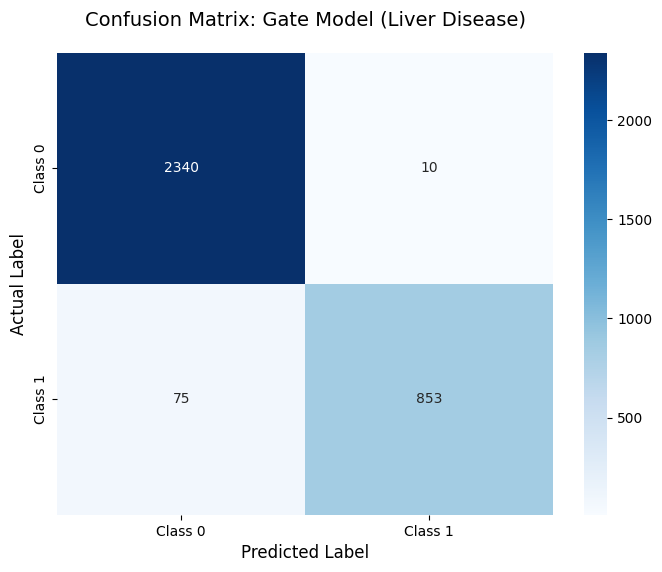

Model saved successfully: gate_model.pkl


In [6]:
"""
    - Target: Ascites (0 = Healthy, 1 = Patient)

Author: Yahya Zuher
Project: AI-Liver-Diseases-Diagnosis-System
"""
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration
DATASET_FILENAME = 'Liver_Patient_Dataset_Cleaned_19k.csv'
MODEL_FILENAME = 'gate_model.pkl'
CONFUSION_MATRIX_FILENAME = 'confusion_matrix_gate.png'

# Direct link to the raw CSV file on GitHub
GITHUB_RAW_URL = 'https://raw.githubusercontent.com/yahyazuher/AI-Liver-Diseases-Diagnosis-System/main/data/processed/Liver_Patient_Dataset_Cleaned_19k.csv'

def download_dataset_if_missing():
    if not os.path.exists(DATASET_FILENAME):
        try:
            print(f"Dataset not found locally. Downloading from {GITHUB_RAW_URL}...")
            # Read CSV directly from the raw GitHub URL
            df = pd.read_csv(GITHUB_RAW_URL)
            # Save to local disk for future runs
            df.to_csv(DATASET_FILENAME, index=False)
            print("Download successful. Dataset saved locally.")
        except Exception as e:
            print(f"Error downloading dataset: {e}")
            sys.exit(1)

def train_liver_prediction_model():
    print("Starting Liver Disease Prediction Pipeline...")

    # 1. Data Acquisition
    download_dataset_if_missing()

    print("Loading dataset...")
    df = pd.read_csv(DATASET_FILENAME)

    # Remove any inadvertent missing values
    df = df.dropna()

    # Separate features (X) and target variable (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # 2. Label Encoding
    # Transforms target labels: 1 (Patient) -> 0, 2 (Healthy) -> 1
    # Note: Usually LabelEncoder will map 1->0 and 2->1 if those are the unique values.
    # Ensure this mapping aligns with your project logic (0=Patient, 1=Healthy or vice versa).
    # Typically in binary classification, 1 is the positive class (Patient).
    le = LabelEncoder()
    y = le.fit_transform(y)

    # 3. Train-Test Split
    # Stratify ensures the training and test sets have the same proportion of class labels
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 4. Model Initialization
    print("Training XGBoost Classifier...")
    # Hyperparameters are set to prevent overfitting on the cleaned dataset
    model = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    )

    # 5. Model Training
    model.fit(X_train, y_train)

    # 6. Evaluation
    print("Evaluating Model Performance...")
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print("-" * 40)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("-" * 40)
    print(classification_report(y_test, y_pred))

    # ================================================================
    # SECTION: CONFUSION MATRIX VISUALIZATION (BINARY)
    # ================================================================
    # This matrix evaluates the Gate Model's ability to distinguish
    # between Healthy individuals and Patients.
    # - False Negatives: Patients incorrectly classified as Healthy (High Risk).
    # - False Positives: Healthy individuals incorrectly flagged as Patients.
    # ================================================================

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])

    plt.title('Confusion Matrix: Gate Model (Liver Disease)', fontsize=14, pad=20)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)

    print(f"Saving confusion matrix to {CONFUSION_MATRIX_FILENAME}...")
    plt.savefig(CONFUSION_MATRIX_FILENAME, dpi=300, bbox_inches='tight')
    plt.show()

    # ================================================================
    # END VISUALIZATION
    # ================================================================

    # 7. Serialization
    # Save the trained model to a file
    joblib.dump(model, MODEL_FILENAME)
    print(f"Model saved successfully: {MODEL_FILENAME}")

if __name__ == "__main__":
    train_liver_prediction_model()

## Test

In [ ]:
import pandas as pd
import joblib
import os
import sys
import requests

# Configuration
MODEL_FILENAME = 'gate_model.pkl'

# Direct link to the raw binary model file
GITHUB_MODEL_URL = 'https://raw.githubusercontent.com/yahyazuher/AI-Liver-Diseases-Diagnosis-System/main/models/gate_model.pkl'

def download_model_if_missing():
    if not os.path.exists(MODEL_FILENAME):
        print(f"Model '{MODEL_FILENAME}' not found locally.")
        print(f"Downloading pre-trained model from GitHub...")

        try:
            response = requests.get(GITHUB_MODEL_URL)
            response.raise_for_status() # Check for HTTP errors

            with open(MODEL_FILENAME, 'wb') as f:
                f.write(response.content)

            print("Download successful. Model saved locally.")

        except Exception as e:
            print(f"Error downloading model: {e}")
            sys.exit(1)
    else:
        print(f"Loading local model: {MODEL_FILENAME}")

def run_prediction_tests():
    # 1. Ensure Model is Available
    download_model_if_missing()

    try:
        model = joblib.load(MODEL_FILENAME)
    except Exception as e:
        print(f"Error loading model file: {e}")
        sys.exit(1)

    # 2. Define Test Data (10 Cases)
    # Feature Order: [Age, Gender, TB, DB, Alkphos, Sgpt, Sgot, TP, ALB, A/G Ratio]
    # Gender Encoding: Male=1, Female=0
    new_patients_data = [
        [45, 1, 8.5, 4.5, 400, 200, 180, 6.8, 3.0, 0.80], # Case 1: Sick (High enzymes/bilirubin)
        [60, 1, 2.5, 1.2, 200, 45,  60,  5.0, 1.8, 0.50], # Case 2: Sick (Low albumin)
        [30, 0, 15.0, 8.0, 550, 120, 110, 7.0, 3.2, 0.80],# Case 3: Sick (Acute hepatitis signs)
        [50, 1, 3.0, 1.5, 290, 80,  250, 6.0, 2.8, 0.85], # Case 4: Sick (Alcoholic liver damage pattern)
        [40, 1, 1.5, 0.6, 190, 150, 140, 7.2, 3.8, 1.10], # Case 5: Sick (Fatty liver signs)
        [75, 0, 5.2, 2.8, 600, 40,  80,  4.5, 1.5, 0.50], # Case 6: Sick (Critical condition)
        [25, 1, 0.7, 0.1, 150, 20,  22,  7.5, 4.0, 1.10], # Case 7: Healthy
        [35, 0, 0.9, 0.2, 180, 25,  19,  6.8, 3.5, 1.00], # Case 8: Borderline (Slightly elevated Alkphos)
        [65, 1, 1.0, 0.3, 195, 35,  40,  7.0, 3.2, 0.90], # Case 9: Borderline (Elevated Alkphos for age)
        [18, 0, 0.6, 0.1, 140, 15,  18,  7.8, 4.2, 1.20]  # Case 10: Healthy
    ]

    # 3. DataFrame Creation
    # Uses feature_names_in_ to ensure compatibility with the trained model
    try:
        correct_columns = model.feature_names_in_
        patients_df = pd.DataFrame(new_patients_data, columns=correct_columns)
    except AttributeError:
        # Fallback if attribute is missing
        cols = ['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
                'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens',
                'Albumin', 'Albumin_and_Globulin_Ratio']
        patients_df = pd.DataFrame(new_patients_data, columns=cols)

    # 4. Prediction
    print("\nRunning diagnostics on test cases...")
    predictions = model.predict(patients_df)

    # 5. Result Display
    print("-" * 75)
    print(f"{'Case':<5} | {'Expected':<12} | {'Prediction':<22} | {'Result':<10}")
    print("-" * 75)

    for i, result in enumerate(predictions):
        # Determine Label: 0 = Sick, 1 = Healthy (based on LabelEncoder logic)
        if result == 0:
            status_label = "Liver Patient (Sick)"
            icon = "🔴"
        else:
            status_label = "Healthy"
            icon = "🟢"

        # Validation Logic
        if i < 6:
            # Cases 1-6 are clearly Sick
            expected = "Sick"
            is_correct = "PASS" if result == 0 else "FAIL"

        elif i == 7 or i == 8:
            # Cases 8 and 9 (Indices 7 & 8) are medically borderline
            expected = "Very Close"
            is_correct = "BORDERLINE"

        else:
            # Cases 7 and 10 are clearly Healthy
            expected = "Healthy"
            is_correct = "PASS" if result == 1 else "FAIL"

        print(f"{i+1:<5} | {expected:<12} | {icon} {status_label:<20} | {is_correct}")
    print("-" * 75)

if __name__ == "__main__":
    run_prediction_tests()

Loading local model: gate_model.pkl

Running diagnostics on test cases...
---------------------------------------------------------------------------
Case  | Expected     | Prediction             | Result    
---------------------------------------------------------------------------
1     | Sick         | 🔴 Liver Patient (Sick) | PASS
2     | Sick         | 🔴 Liver Patient (Sick) | PASS
3     | Sick         | 🔴 Liver Patient (Sick) | PASS
4     | Sick         | 🔴 Liver Patient (Sick) | PASS
5     | Sick         | 🔴 Liver Patient (Sick) | PASS
6     | Sick         | 🔴 Liver Patient (Sick) | PASS
7     | Healthy      | 🟢 Healthy              | PASS
8     | Very Close   | 🔴 Liver Patient (Sick) | BORDERLINE
9     | Very Close   | 🔴 Liver Patient (Sick) | BORDERLINE
10    | Healthy      | 🟢 Healthy              | PASS
---------------------------------------------------------------------------


# Hepatitis_C 3Models

## Complications Model


 Dataset loaded successfully: 418 records.

 Starting Complications Model Training...
 Features used (14): ['Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Age', 'Sex', 'Hepatomegaly', 'Spiders', 'Edema']
 Training XGBoost model...
----------------------------------------
 Accuracy: 95.24%
----------------------------------------
              precision    recall  f1-score   support

  No Ascites       0.96      0.99      0.97        79
     Ascites       0.67      0.40      0.50         5

    accuracy                           0.95        84
   macro avg       0.81      0.69      0.74        84
weighted avg       0.95      0.95      0.95        84

 Saving confusion matrix to confusion_matrix_complications.png...


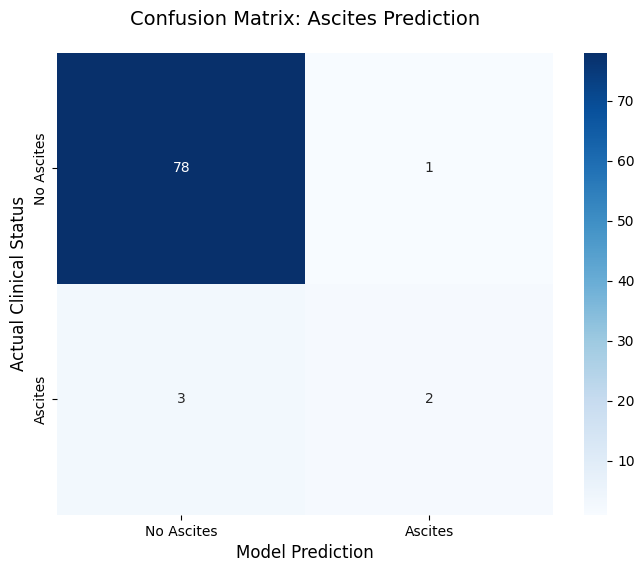

 Saving model to hepatitis_complications.pkl...
 Model saved successfully.


In [1]:
"""
    - Source: HepatitisC.csv (Processed)
    - Target: Ascites (0 = No, 1 = Yes)

Author: Yahya Zuher
Project: AI-Liver-Diseases-Diagnosis-System
"""

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import requests
import io
import sys
import seaborn as sns
import matplotlib.pyplot as plt

# --- Configuration ---
DATA_URL = 'https://raw.githubusercontent.com/yahyazuher/AI-Liver-Diseases-Diagnosis-System/main/data/processed/HepatitisC.csv'
MODEL_FILENAME = 'hepatitis_complications.pkl'
CONFUSION_MATRIX_FILENAME = 'confusion_matrix_complications.png'

def load_data():
    """Fetches the dataset directly from the GitHub repository."""
    print(f" Downloading dataset from GitHub...")
    try:
        response = requests.get(DATA_URL)
        response.raise_for_status()
        df = pd.read_csv(io.StringIO(response.text))
        print(f" Dataset loaded successfully: {len(df)} records.")
        return df
    except Exception as e:
        sys.exit(f" Error downloading data: {e}")

def train_model():
    # 1. Load Data
    df = load_data()

    print("\n Starting Complications Model Training...")

    # 2. Feature Selection
    # Dropping 'Stage' and 'Status' to ensure the model relies only on raw biomarkers
    features_to_drop = ['Ascites', 'Status', 'Stage', 'ID', 'N_Days']

    X = df.drop(columns=features_to_drop, errors='ignore')
    y = df['Ascites']

    print(f" Features used ({len(X.columns)}): {list(X.columns)}")

    # 3. Split Data (80% Train, 20% Test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 4. Handle Class Imbalance (Calculate Ratio)
    # This ensures the model pays attention to the minority class (Ascites cases)
    ratio = float(len(y_train[y_train == 0])) / len(y_train[y_train == 1])

    # 5. Initialize XGBoost Classifier
    model = xgb.XGBClassifier(
        n_estimators=150,       # Number of trees
        learning_rate=0.05,     # Step size shrinkage
        max_depth=4,            # Tree depth (prevent overfitting)
        subsample=0.8,          # Data sampling ratio per tree
        colsample_bytree=0.8,   # Feature sampling ratio
        scale_pos_weight=ratio, # Automatically balance classes
        eval_metric='logloss',
        random_state=42
    )

    # 6. Train
    print(" Training XGBoost model...")
    model.fit(X_train, y_train)

    # 7. Evaluate
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred) * 100

    print("-" * 40)
    print(f" Accuracy: {acc:.2f}%")
    print("-" * 40)
    print(classification_report(y_test, y_pred, target_names=['No Ascites', 'Ascites']))

    # ================================================================
    # SECTION: CONFUSION MATRIX VISUALIZATION
    # ================================================================
    # Note: The Confusion Matrix provides a granular view of prediction performance.
    # In clinical diagnostics, this is critical for distinguishing between:
    # - False Negatives: Missing a case of Ascites (High Risk).
    # - False Positives: Incorrectly flagging a healthy patient (Anxiety/Cost).
    # The heatmap below visualizes these metrics using the Test Set.
    # ================================================================

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['No Ascites', 'Ascites'],
                yticklabels=['No Ascites', 'Ascites'])

    plt.title('Confusion Matrix: Ascites Prediction', fontsize=14, pad=20)
    plt.ylabel('Actual Clinical Status', fontsize=12)
    plt.xlabel('Model Prediction', fontsize=12)

    print(f" Saving confusion matrix to {CONFUSION_MATRIX_FILENAME}...")
    plt.savefig(CONFUSION_MATRIX_FILENAME, dpi=300, bbox_inches='tight')
    plt.show()

    # ================================================================
    # END VISUALIZATION
    # ================================================================

    # 8. Save
    print(f" Saving model to {MODEL_FILENAME}...")
    joblib.dump(model, MODEL_FILENAME)
    print(f" Model saved successfully.")

if __name__ == "__main__":
    train_model()

## Stage Model

Starting Training Pipeline...
Training model...

Evaluation Results:
 Accuracy: 62.50%
              precision    recall  f1-score   support

     Stage 1       0.54      0.72      0.62        83
     Stage 2       0.57      0.29      0.38        83
     Stage 3       0.75      0.87      0.80        82

    accuracy                           0.62       248
   macro avg       0.62      0.63      0.60       248
weighted avg       0.62      0.62      0.60       248

 Saving confusion matrix to confusion_matrix_stage.png...


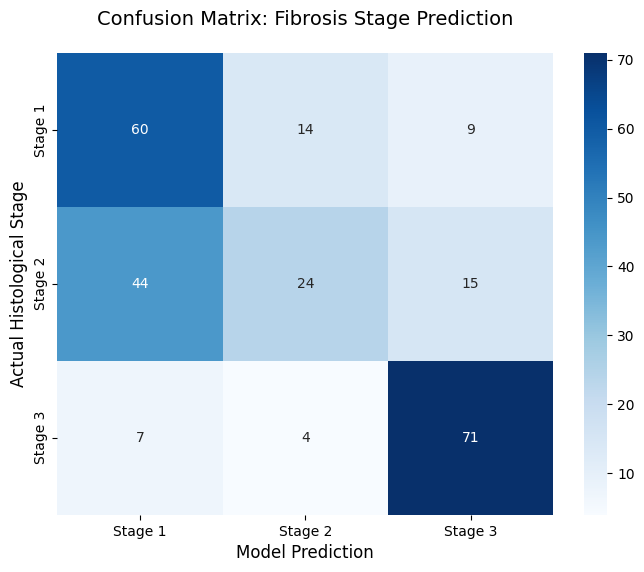

Retraining on full data and saving...
Saved: hepatitisC_stage_model.pkl


In [3]:
"""
Project: AI-Liver-Diseases-Diagnosis-System
Description: Trains an XGBoost classifier to predict liver disease stages (1, 2, 3)
             using blood biomarkers and engineered features (APRI,Bilirubin x Albumin,Copper / Platelets.).
"""

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt

# --- Configuration ---
DATASET_URL = 'https://raw.githubusercontent.com/yahyazuher/AI-Liver-Diseases-Diagnosis-System/main/data/processed/hepatitisC_Stage.csv'
LOCAL_FILENAME = 'hepatitisC_Stage.csv'
MODEL_FILENAME = 'hepatitisC_stage_model.pkl'
CONFUSION_MATRIX_FILENAME = 'confusion_matrix_stage.png'

COLUMN_NAMES = [
    'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
    'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
    'Stage', 'Status', 'Age', 'Sex', 'Ascites',
    'Hepatomegaly', 'Spiders', 'Edema'
]

def get_dataset():
    """Downloads dataset if not available locally."""
    if not os.path.exists(LOCAL_FILENAME):
        try:
            print("⬇Downloading dataset...")
            df = pd.read_csv(DATASET_URL)
            if len(df.columns) == len(COLUMN_NAMES):
                df.columns = COLUMN_NAMES
            df.to_csv(LOCAL_FILENAME, index=False)
        except Exception as e:
            sys.exit(f"Error downloading data: {e}")
    return pd.read_csv(LOCAL_FILENAME)

def add_medical_features(df):
    """Calculates APRI score and other medical interaction terms."""
    df_eng = df.copy()
    # APRI: AST to Platelet Ratio Index
    df_eng['APRI'] = ((df_eng['SGOT'] / 40.0) / (df_eng['Platelets'] + 0.1)) * 100
    # Liver Function Synthesis
    df_eng['Bilirubin_Albumin'] = df_eng['Bilirubin'] * df_eng['Albumin']
    # Copper/Platelet Ratio
    df_eng['Copper_Platelets'] = df_eng['Copper'] / (df_eng['Platelets'] + 1)
    return df_eng

def train():
    print("Starting Training Pipeline...")

    # 1. Load & Engineer Features
    df = get_dataset()
    df = add_medical_features(df)

    # 2. Prepare Data
    X = df.drop(columns=['Stage'])
    y = df['Stage']

    # Map Targets: 1->0 (Early), 2->1 (Fibrosis), 3->2 (Cirrhosis)
    # This is necessary because XGBoost expects classes starting from 0
    y = pd.to_numeric(y, errors='coerce').fillna(0).astype(int)
    y = y.map({1: 0, 2: 1, 3: 2}).astype(int)

    # 3. Preprocessing
    numeric_features = X.select_dtypes(include=['number']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    # 4. XGBoost Model (Optimized Parameters)
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(
            n_estimators=200,
            learning_rate=0.01,
            max_depth=3,
            min_child_weight=5,
            gamma=0.1,
            subsample=0.7,
            colsample_bytree=0.8,
            objective='multi:softprob', # Multi-class classification
            num_class=3,                # 3 specific classes (Stage 1, 2, 3)
            eval_metric='mlogloss',
            n_jobs=-1,
            random_state=42
        ))
    ])

    # 5. Train & Evaluate
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("Training model...")
    model.fit(X_train, y_train)

    print("\nEvaluation Results:")
    y_pred = model.predict(X_test)
    print(f" Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print(classification_report(y_test, y_pred, target_names=['Stage 1', 'Stage 2', 'Stage 3']))

    # ================================================================
    # SECTION: CONFUSION MATRIX VISUALIZATION (MULTI-CLASS)
    # ================================================================
    # This matrix visualizes the classification accuracy across three distinct
    # histological stages (1, 2, and 3).
    # Diagonal elements represent correct classifications.
    # Off-diagonal elements represent 'Confusion' (e.g., misclassifying Stage 2 as Stage 1).
    # ================================================================

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Stage 1', 'Stage 2', 'Stage 3'],
                yticklabels=['Stage 1', 'Stage 2', 'Stage 3'])

    plt.title('Confusion Matrix: Fibrosis Stage Prediction', fontsize=14, pad=20)
    plt.ylabel('Actual Histological Stage', fontsize=12)
    plt.xlabel('Model Prediction', fontsize=12)

    print(f" Saving confusion matrix to {CONFUSION_MATRIX_FILENAME}...")
    plt.savefig(CONFUSION_MATRIX_FILENAME, dpi=300, bbox_inches='tight')
    plt.show()

    # ================================================================
    # END VISUALIZATION
    # ================================================================

    # 6. Save Final Model
    print("Retraining on full data and saving...")
    model.fit(X, y)
    joblib.dump(model, MODEL_FILENAME)
    print(f"Saved: {MODEL_FILENAME}")

if __name__ == "__main__":
    train()

## Status Model

Starting Automated Training Pipeline...
⬇Downloading dataset from GitHub...
Successfully loaded 312 records.
Training model on remote data...

Final Validation Results:
Accuracy: 71.43%
------------------------------
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        38
           1       0.62      0.72      0.67        25

    accuracy                           0.71        63
   macro avg       0.71      0.72      0.71        63
weighted avg       0.73      0.71      0.72        63

 Saving confusion matrix to confusion_matrix_status.png...


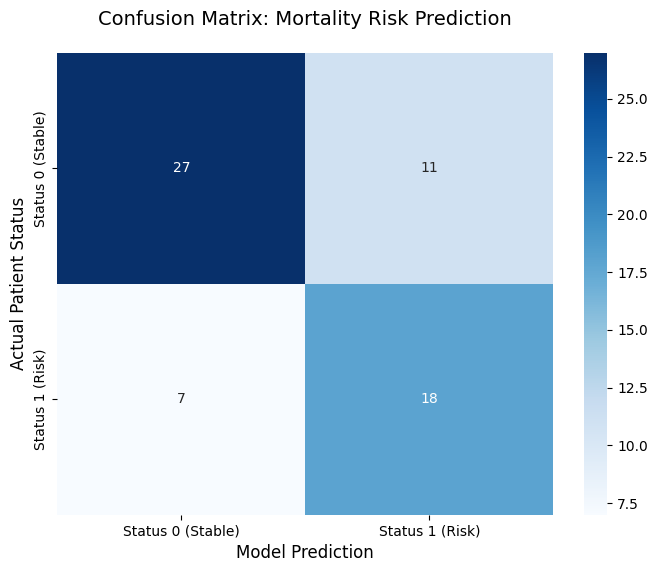

Saving model locally: hepatitisC_status_model.pkl


In [5]:
"""
Project: AI-Liver-Diseases-Diagnosis-System
Developer: Yahya Zuher
Description: This script fetches training data directly from GitHub and trains
             an optimized XGBoost model for status prediction.
"""

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt

# --- Configuration (GitHub Integration) ---
RAW_DATA_URL = 'https://raw.githubusercontent.com/yahyazuher/AI-Liver-Diseases-Diagnosis-System/main/data/processed/hepatitisC_status.csv'
MODEL_FILENAME = 'hepatitisC_status_model.pkl'
CONFUSION_MATRIX_FILENAME = 'confusion_matrix_status.png'

def get_live_dataset():
    """Downloads the dataset from GitHub."""
    try:
        print(f"⬇Downloading dataset from GitHub...")
        df = pd.read_csv(RAW_DATA_URL)
        print(f"Successfully loaded {len(df)} records.")
        return df
    except Exception as e:
        sys.exit(f"Critical Error: Could not fetch data. {e}")

def add_medical_features(df):
    """Adds ALBI and APRI features for high-precision mortality prediction."""
    df_eng = df.copy()

    # 1. APRI Score
    df_eng['APRI'] = ((df_eng['SGOT'] / 40.0) / (df_eng['Platelets'] + 0.1)) * 100

    # 2. ALBI Score (Log-based liver function assessment)
    df_eng['ALBI_Score'] = (np.log10(df_eng['Bilirubin'].clip(lower=0.1) * 17.1) * 0.66) + \
                            (df_eng['Albumin'] * 10 * -0.085)

    # 3. Bilirubin to Albumin Ratio
    df_eng['Bili_Alb_Ratio'] = df_eng['Bilirubin'] / (df_eng['Albumin'] + 0.1)

    return df_eng

def run_pipeline():
    print("Starting Automated Training Pipeline...")

    # 1. Get Data from GitHub
    df = get_live_dataset()

    # 2. Add Engineered Features
    df = add_medical_features(df)

    # 3. Define Features & Target
    # We exclude 'Status' (Target) and 'Stage' (due to its low accuracy)
    X = df.drop(columns=['Status', 'Stage'], errors='ignore')
    y = df['Status'].astype(int)

    # 4. Preprocessing Layers
    numeric_features = X.select_dtypes(include=['number']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    # 5. XGBoost Model Configuration (Tuned for 125/187 ratio)
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(
            n_estimators=250,
            learning_rate=0.03,
            max_depth=4,
            scale_pos_weight=1.5, # Balance for your specific dataset
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary:logistic',
            eval_metric='logloss',
            random_state=42
        ))
    ])

    # 6. Stratified Train-Test Split (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 7. Model Training
    print("Training model on remote data...")
    model.fit(X_train, y_train)

    # 8. Evaluation
    y_pred = model.predict(X_test)
    print("\nFinal Validation Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print("-" * 30)
    print(classification_report(y_test, y_pred))

    # ================================================================
    # SECTION: CONFUSION MATRIX VISUALIZATION (BINARY)
    # ================================================================
    # This matrix evaluates the model's ability to predict patient mortality risk.
    # It specifically highlights:
    # - True Positives: Correctly identifying high-risk patients.
    # - False Negatives: Critical misses where a high-risk patient is classified as stable.
    # ================================================================

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Status 0 (Stable)', 'Status 1 (Risk)'],
                yticklabels=['Status 0 (Stable)', 'Status 1 (Risk)'])

    plt.title('Confusion Matrix: Mortality Risk Prediction', fontsize=14, pad=20)
    plt.ylabel('Actual Patient Status', fontsize=12)
    plt.xlabel('Model Prediction', fontsize=12)

    print(f" Saving confusion matrix to {CONFUSION_MATRIX_FILENAME}...")
    plt.savefig(CONFUSION_MATRIX_FILENAME, dpi=300, bbox_inches='tight')
    plt.show()

    # ================================================================
    # END VISUALIZATION
    # ================================================================

    # 9. Global Save
    print(f"Saving model locally: {MODEL_FILENAME}")
    model.fit(X, y) # Retrain on full dataset
    joblib.dump(model, MODEL_FILENAME)

if __name__ == "__main__":
    run_pipeline()

## HC Test

In [ ]:
"""
AI Liver Disease Diagnosis System
--------------------------------------------------------
Created by: Yahya Zuher
Project: AI-Liver-Diseases-Diagnosis-System

    - FEATURES: Auto-downloads missing models from GitHub.
    - RUNS: Inference on standard test cases.
"""

import pandas as pd
import joblib
import numpy as np
import math
import os
import sys
import requests

class LiverDiseasePredictor:
    def __init__(self, model_path='models'):
        self.model_path = model_path
        self.models = {}
        # Base URL for Raw GitHub Files (Used for auto-download)
        self.repo_url = "https://raw.githubusercontent.com/yahyazuher/AI-Liver-Diseases-Diagnosis-System/main/models/"

        # Standard 15-column input structure
        self.raw_input_cols = [
            'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
            'Tryglicerides', 'Platelets', 'Prothrombin', 'Age', 'Sex',
            'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'
        ]

    def _download_file(self, filename):
        """Helper to download a missing model file directly from GitHub."""
        url = self.repo_url + filename
        local_path = os.path.join(self.model_path, filename)

        print(f"  Model '{filename}' missing locally. Downloading from GitHub...")
        try:
            os.makedirs(self.model_path, exist_ok=True)
            response = requests.get(url)
            response.raise_for_status()
            with open(local_path, 'wb') as f:
                f.write(response.content)
            print(f" Downloaded: {local_path}")
            return True
        except Exception as e:
            print(f" Failed to download {filename}: {e}")
            return False

    def load_models(self):
        """Loads models. If a file is missing, it attempts to download it."""
        # UPDATED: Exact filenames as per your GitHub repo
        filenames = {
            'stage': 'hepatitisC_stage_model.pkl',
            'status': 'hepatitisC_status_model.pkl',
            'comp': 'hepatitisC_complications.pkl'  # Corrected Name
        }

        print(f"Initializing AiLDS Models...")
        all_loaded = True

        for key, name in filenames.items():
            path = os.path.join(self.model_path, name)

            # 1. Check existence, if not -> Download
            if not os.path.exists(path):
                success = self._download_file(name)
                if not success:
                    all_loaded = False
                    continue

            # 2. Load Model
            try:
                self.models[key] = joblib.load(path)
            except Exception as e:
                print(f"Error loading {name}: {e}")
                all_loaded = False

        if all_loaded:
            print("All AiLDS models loaded and synchronized.\n")
            return True
        else:
            print("Critical Error: One or more models could not be loaded.\n")
            return False

    def _prepare_dataframes(self, row):
        """
        Calculates medical indices and constructs specific DataFrames.
        """
        # 1. Feature Engineering
        apri = ((row['SGOT'] / 40.0) / (row['Platelets'] + 0.1)) * 100
        bili_adj = max(row['Bilirubin'], 0.1)
        albi = (math.log10(bili_adj * 17.1) * 0.66) + (row['Albumin'] * 10 * -0.085)

        bili_alb = row['Bilirubin'] * row['Albumin']
        copper_plat = row['Copper'] / (row['Platelets'] + 1)
        bili_alb_ratio = row['Bilirubin'] / (row['Albumin'] + 0.1)

        data = row.to_dict()
        data['APRI'] = apri
        data['ALBI_Score'] = albi
        data['Bilirubin_Albumin'] = bili_alb
        data['Copper_Platelets'] = copper_plat
        data['Bili_Alb_Ratio'] = bili_alb_ratio
        data['Status'] = 0

        # 2. Construct Model-Specific DataFrames

        # A. Stage Model (19 Features)
        stage_cols = [
            'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
            'Tryglicerides', 'Platelets', 'Prothrombin', 'Status', 'Age', 'Sex',
            'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'APRI',
            'Bilirubin_Albumin', 'Copper_Platelets'
        ]
        df_stage = pd.DataFrame([data], columns=stage_cols)

        # B. Status Model (18 Features)
        status_cols = [
            'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
            'Tryglicerides', 'Platelets', 'Prothrombin', 'Age', 'Sex',
            'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'APRI',
            'ALBI_Score', 'Bili_Alb_Ratio'
        ]
        df_status = pd.DataFrame([data], columns=status_cols)

        # C. Complications Model (14 Features)
        comp_cols = [
            'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
            'Tryglicerides', 'Platelets', 'Prothrombin', 'Age', 'Sex',
            'Hepatomegaly', 'Spiders', 'Edema'
        ]
        df_comp = pd.DataFrame([data], columns=comp_cols)

        return df_stage, df_status, df_comp, apri, albi

    def run_diagnosis(self, patients_list):
        if not self.models and not self.load_models():
            return

        df_input = pd.DataFrame(patients_list, columns=self.raw_input_cols)

        for i in range(len(df_input)):
            patient_row = df_input.iloc[i]
            df_stage, df_status, df_comp, apri, albi = self._prepare_dataframes(patient_row)

            # --- INFERENCE ---
            # 1. Stage
            stage_pred = self.models['stage'].predict(df_stage)[0]
            if stage_pred == 0: stage_pred = 1 # Correction map

            # 2. Ascites Risk
            ascites_risk = self.models['comp'].predict_proba(df_comp)[:, 1][0]

            # 3. Mortality Risk
            death_risk = self.models['status'].predict_proba(df_status)[:, 1][0]

            # --- REPORT ---
            print(f"Case #{i+1} | AI Clinical Report")
            print("-" * 50)
            print(f"Indices:      APRI: {apri:.2f} | ALBI: {albi:.2f}")
            print(f"AI Stage:     Stage {stage_pred} (Histological)")
            print(f"Ascites Risk: {ascites_risk*100:.1f}%")
            print(f"Survival Risk:{death_risk*100:.1f}%")

            if death_risk > 0.5:
                print(" ASSESSMENT:   CRITICAL - Immediate intervention required.")
            elif ascites_risk > 0.5:
                print(" ASSESSMENT:   WARNING - High risk of decompensation.")
            else:
                print(" ASSESSMENT:   STABLE - Continue routine monitoring.")
            print("=" * 50 + "\n")

if __name__ == "__main__":
    # Test Data (7 Cases)
    test_data = [
        [0.7, 242.0, 4.08, 73.0, 5890.0, 56.76, 118.0, 300.0, 10.6, 53.0, 1, 0, 0, 0, 0],   # Healthy
        [3.2, 562.0, 3.08, 79.0, 2276.0, 144.15, 88.0, 251.0, 11.0, 53.0, 0, 0, 0, 1, 0],   # Acute
        [1.1, 302.0, 4.14, 54.0, 7394.8, 113.52, 88.0, 221.0, 10.6, 58.0, 0, 0, 1, 1, 0],   # Fibrosis
        [0.6, 252.0, 3.83, 41.0, 843.0, 65.1, 83.0, 336.0, 11.4, 59.0, 1, 0, 1, 1, 0],      # Compensated
        [14.5, 261.0, 2.6, 156.0, 1718.0, 137.95, 172.0, 190.0, 12.2, 58.0, 0, 1, 1, 1, 1], # Decompensated
        [3.6, 236.0, 3.52, 94.0, 591.0, 82.15, 95.0, 71.0, 13.6, 53.0, 0, 0, 0, 1, 0],      # Active
        [1.8, 244.0, 2.54, 64.0, 6121.8, 60.63, 92.0, 183.0, 10.3, 70.0, 0, 1, 1, 1, 0.5]   # Geriatric
    ]

    predictor = LiverDiseasePredictor(model_path='models')
    predictor.run_diagnosis(test_data)

Initializing AiLDS Models...
  Model 'hepatitisC_stage_model.pkl' missing locally. Downloading from GitHub...
 Downloaded: models/hepatitisC_stage_model.pkl
  Model 'hepatitisC_status_model.pkl' missing locally. Downloading from GitHub...
 Downloaded: models/hepatitisC_status_model.pkl
  Model 'hepatitisC_complications.pkl' missing locally. Downloading from GitHub...
 Downloaded: models/hepatitisC_complications.pkl
All AiLDS models loaded and synchronized.

Case #1 | AI Clinical Report
--------------------------------------------------
Indices:      APRI: 0.47 | ALBI: -2.76
AI Stage:     Stage 1 (Histological)
Ascites Risk: 0.3%
Survival Risk:12.3%
 ASSESSMENT:   STABLE - Continue routine monitoring.

Case #2 | AI Clinical Report
--------------------------------------------------
Indices:      APRI: 1.44 | ALBI: -1.47
AI Stage:     Stage 1 (Histological)
Ascites Risk: 2.1%
Survival Risk:91.7%
 ASSESSMENT:   CRITICAL - Immediate intervention required.

Case #3 | AI Clinical Report
-----

# Fatty Liver



--- Initializing Fatty Liver (NAFLD) Diagnostic System ---
Accessing remote repository: https://raw.githubusercontent.com/yahyazuher/AI-Liver-Diseases-Diagnosis-System/main/data/processed/FattyLiver.csv
Dataset synchronized successfully. Total records: 6543
Cleaned dataset ready for training: 6533 samples

Training diagnostic model on clinical biomarkers...

Model Validation Accuracy: 100.00%
---------------------------------------------
Detailed Classification Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1178
           1       1.00      1.00      1.00       129

    accuracy                           1.00      1307
   macro avg       1.00      1.00      1.00      1307
weighted avg       1.00      1.00      1.00      1307



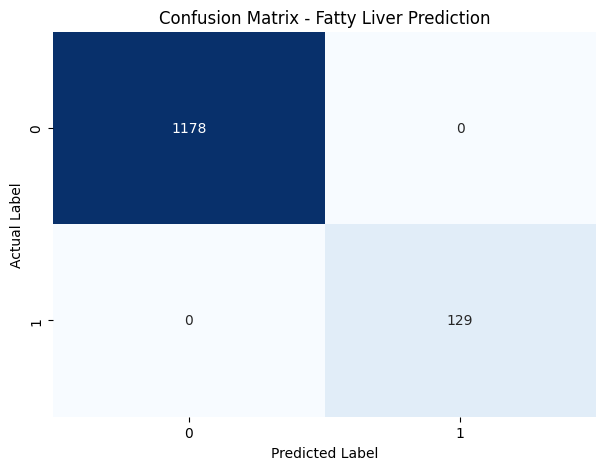


✔ Module finalized and saved as: fatty_liver_model.pkl


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

# =================================================================
# Fatty Liver (NAFLD) Diagnostic Module
# Project: AI-Liver-Diseases-Diagnosis-System
# Author: Yahya Zuher
# =================================================================

print("--- Initializing Fatty Liver (NAFLD) Diagnostic System ---")


RAW_DATA_URL = "https://raw.githubusercontent.com/yahyazuher/AI-Liver-Diseases-Diagnosis-System/main/data/processed/FattyLiver.csv"

try:
    print(f"Accessing remote repository: {RAW_DATA_URL}")
    df = pd.read_csv(RAW_DATA_URL)
    print(f"Dataset synchronized successfully. Total records: {len(df)}")
except Exception as e:
    print(f"Error: Connection to repository failed. {e}")
    raise SystemExit

# ---------------------------------------------------------
# 2. Data Preprocessing & Cleaning
# ---------------------------------------------------------
# Sanitizing column headers and ensuring numeric integrity
df.columns = df.columns.str.strip()
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Removing incomplete clinical records
df = df.dropna()
print(f"Cleaned dataset ready for training: {len(df)} samples")

# ---------------------------------------------------------
# 3. Clinical Target Engineering (NAFLD Logic)
# ---------------------------------------------------------
def clinical_diagnosis_logic(row):
    """
    Logic: Positive diagnosis if (Triglycerides > 150 mg/dL AND (ALT > 40 U/L OR GGT > 40 U/L))
    or if both liver enzymes (ALT & GGT) are significantly elevated.
    """
    trig_high = row['Triglycerides'] > 150
    alt_high = row['ALT'] > 40
    ggt_high = row['GGT'] > 40

    if (trig_high and (alt_high or ggt_high)) or (alt_high and ggt_high):
        return 1  # NAFLD Detected
    return 0      # Healthy

df['Diagnosis'] = df.apply(clinical_diagnosis_logic, axis=1)

# ---------------------------------------------------------
# 4. Feature Selection & Data Splitting
# ---------------------------------------------------------
# Removing target and identification columns (SEQN is a sequence ID)
X = df.drop(['Diagnosis'], axis=1)
if 'SEQN' in X.columns:
    X = X.drop(['SEQN'], axis=1)
y = df['Diagnosis']

# 80/20 Train-Test split for robust validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------------------------------------
# 5. Model Training (Optimized XGBoost)
# ---------------------------------------------------------
print("\nTraining diagnostic model on clinical biomarkers...")
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    eval_metric='logloss',
)

model.fit(X_train, y_train)

# ---------------------------------------------------------
# 6. Evaluation & Statistical Metrics
# ---------------------------------------------------------
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Validation Accuracy: {accuracy * 100:.2f}%")
print("-" * 45)
print("Detailed Classification Performance:")
print(classification_report(y_test, y_pred))

# Visualizing Confusion Matrix

plt.figure(figsize=(7, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Fatty Liver Prediction')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# ---------------------------------------------------------
# 7. Model Serialization (Pickle Export)
# ---------------------------------------------------------
MODEL_EXPORT_NAME = "fatty_liver_model.pkl"
with open(MODEL_EXPORT_NAME, "wb") as f:
    pickle.dump(model, f)

print(f"\n✔ Module finalized and saved as: {MODEL_EXPORT_NAME}")


## Test

In [ ]:
import pandas as pd
import joblib
import os
import requests
import io

def load_model():
    """
    Downloads and loads the pre-trained "fatty_liver_model.pkl" XGBoost model directly from GitHub.
    """
    model_url = 'https://github.com/yahyazuher/AI-Liver-Diseases-Diagnosis-System/raw/main/models/fatty_liver_model.pkl'

    try:
        print(f"Connecting to GitHub to fetch model...")
        response = requests.get(model_url)

        # Check if the download was successful (HTTP 200)
        if response.status_code == 200:
            # Wrap the raw bytes in a BytesIO object so joblib can read it like a file
            return joblib.load(io.BytesIO(response.content))
        else:
            raise Exception(f"Failed to download model. Status code: {response.status_code}")

    except Exception as e:
        print(f"Cloud Load Failed: {e}")
        # Fallback: Try to find the file locally if the internet is down
        model_filename = 'fatty_liver_model.pkl'
        if os.path.exists(model_filename):
            print("Local backup found. Loading from disk...")
            return joblib.load(model_filename)
        else:
            raise FileNotFoundError("Critical Error: Model not found online or locally.")

if __name__ == "__main__":
    try:
        model = load_model()
        print("Model loaded successfully from GitHub!")
    except Exception as e:
        print(f"Initialization Error: {e}")
        exit()

    # Feature labels (13 mandatory clinical inputs)
    columns = [
        'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol',
        'Creatinine', 'Glucose', 'GGT', 'Bilirubin',
        'Triglycerides', 'Uric_Acid', 'Platelets', 'HDL'
    ]

    print("\n" + "="*75)
    print("VIRTUAL CLINIC: FATTY LIVER (NAFLD) MODEL VALIDATION")
    print("="*75)

    # Clinical scenarios for testing
    cases = [
        {'Case': '1. Healthy Baseline (Athletic)', 'Data': [4.5, 60, 20, 18, 170, 0.9, 85, 25, 0.6, 90, 4.5, 250, 55]},
        {'Case': '2. Isolated Hyperlipidemia', 'Data': [4.2, 70, 22, 20, 240, 1.0, 95, 30, 0.7, 300, 5.2, 230, 40]},
        {'Case': '3. Active NAFLD (Early)', 'Data': [3.8, 40, 45, 55, 210, 1.1, 110, 65, 0.8, 220, 6.5, 210, 35]},
        {'Case': '4. Metabolic Syndrome', 'Data': [3.5, 110, 65, 75, 280, 1.2, 145, 90, 1.1, 450, 8.2, 185, 28]},
        {'Case': '5. Advanced Stress', 'Data': [3.1, 140, 85, 80, 200, 1.3, 130, 110, 1.4, 190, 7.5, 130, 31]},
        {'Case': '6. Non-Fatty Injury', 'Data': [4.0, 65, 130, 160, 165, 0.8, 88, 40, 1.3, 105, 4.2, 245, 52]},
        {'Case': '7. Moderate/Borderline Risk', 'Data': [4.0, 40, 35, 41, 190, 1.0, 105, 39, 0.8, 152, 5.8, 210, 42]},
    ]

    print(f"{'Clinical Scenario':<45} | {'Final Diagnosis'}")
    print("-" * 75)

    for case in cases:
        # Create DataFrame for prediction
        df_test = pd.DataFrame([case['Data']], columns=columns)

        # Get result (0 = Healthy, 1 = NAFLD)
        prediction = model.predict(df_test)[0]
        result_text = "🔴 PATIENT (NAFLD)" if prediction == 1 else "🟢 HEALTHY"

        print(f"{case['Case']:<45} | {result_text}")

    print("-" * 75)
    print("Scientific Logic: Thresholds applied at ALT: 40, AST: 40, Triglycerides: 150.")
    print("="*75)

Connecting to GitHub to fetch model...
Model loaded successfully from GitHub!

VIRTUAL CLINIC: FATTY LIVER (NAFLD) MODEL VALIDATION
Clinical Scenario                             | Final Diagnosis
---------------------------------------------------------------------------
1. Healthy Baseline (Athletic)                | 🟢 HEALTHY
2. Isolated Hyperlipidemia                    | 🟢 HEALTHY
3. Active NAFLD (Early)                       | 🔴 PATIENT (NAFLD)
4. Metabolic Syndrome                         | 🔴 PATIENT (NAFLD)
5. Advanced Stress                            | 🔴 PATIENT (NAFLD)
6. Non-Fatty Injury                           | 🟢 HEALTHY
7. Moderate/Borderline Risk                   | 🔴 PATIENT (NAFLD)
---------------------------------------------------------------------------
Scientific Logic: Thresholds applied at ALT: 40, AST: 40, Triglycerides: 150.


# Cancer Risk Model

--- Initializing Liver Cancer Risk Assessment System ---
Fetching dataset from: https://raw.githubusercontent.com/yahyazuher/AI-Liver-Diseases-Diagnosis-System/main/data/processed/The_Cancer_data_1500.csv
Dataset loaded successfully.
Total records available for processing: 1500

Identified Features for Model Input:
['Age', 'Gender', 'BMI', 'Smoking', 'GeneticRisk', 'PhysicalActivity', 'AlcoholIntake', 'CancerHistory']

Training XGBoost model on diagnostic patterns...

Model Performance Metrics:
Overall Accuracy: 94.00%
----------------------------------------
Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       184
           1       0.95      0.89      0.92       116

    accuracy                           0.94       300
   macro avg       0.94      0.93      0.94       300
weighted avg       0.94      0.94      0.94       300



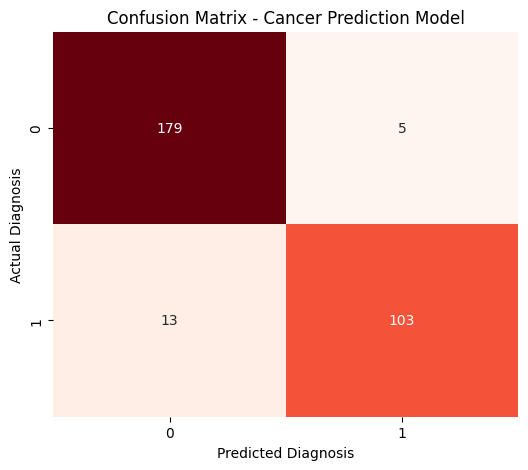


✔ Model successfully serialized as: cancer_model.pkl


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# =================================================================
# Project: AI-Liver-Diseases-Diagnosis-System
# Author: Yahya Zuher
# =================================================================

print("--- Initializing Liver Cancer Risk Assessment System ---")


DATA_URL = "https://raw.githubusercontent.com/yahyazuher/AI-Liver-Diseases-Diagnosis-System/main/data/processed/The_Cancer_data_1500.csv"

try:
    print(f"Fetching dataset from: {DATA_URL}")
    df = pd.read_csv(DATA_URL)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error: Failed to load dataset. {e}")
    raise SystemExit

# Data Cleaning: Ensure no missing values before processing
df = df.dropna()
print(f"Total records available for processing: {len(df)}")

# ---------------------------------------------------------
# 2. Feature Engineering & Preprocessing
# ---------------------------------------------------------
# X: Feature matrix (Age, Smoking, Genetics, Alcohol, etc.)
# y: Target vector (Diagnosis: 0 = Healthy, 1 = Cancer)
X = df.drop(['Diagnosis'], axis=1)
y = df['Diagnosis']

print("\nIdentified Features for Model Input:")
print(list(X.columns))

# Split data: 80% Training - 20% Testing for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------------------------------------
# 3. Model Training (XGBoost Classifier)
# ---------------------------------------------------------
print("\nTraining XGBoost model on diagnostic patterns...")
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    eval_metric='logloss',
)

model.fit(X_train, y_train)

# ---------------------------------------------------------
# 4. Evaluation & Performance Metrics
# ---------------------------------------------------------
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Performance Metrics:")
print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print("-" * 40)
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred))

# Visualizing results via Confusion Matrix

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('Confusion Matrix - Cancer Prediction Model')
plt.xlabel('Predicted Diagnosis')
plt.ylabel('Actual Diagnosis')
plt.show()

# ---------------------------------------------------------
# 5. Model Export for Integration
# ---------------------------------------------------------
# Exporting as a pickle file for use in the AiLDS web application
MODEL_FILENAME = "cancer_model.pkl"
with open(MODEL_FILENAME, "wb") as file:
    pickle.dump(model, file)

print(f"\n✔ Model successfully serialized as: {MODEL_FILENAME}")

## Test

In [ ]:
import pandas as pd
import joblib
import os
import requests
import io

def load_model():
    """
    Downloads and loads the trained XGBoost model from GitHub.
    """
    model_url = 'https://github.com/yahyazuher/AI-Liver-Diseases-Diagnosis-System/raw/main/models/cancer_model.pkl'

    try:
        print(f"Connecting to GitHub to fetch: {model_url.split('/')[-1]}...")
        response = requests.get(model_url)

        # Check if the download was successful
        if response.status_code == 200:
            # Use BytesIO to let joblib read the binary content directly from RAM
            return joblib.load(io.BytesIO(response.content))
        else:
            raise Exception(f"Download failed. Status code: {response.status_code}")

    except Exception as e:
        print(f"Cloud Load Failed: {e}")
        # Fallback: Check if the file exists locally
        model_filename = 'cancer_model.pkl'
        if os.path.exists(model_filename):
            print("Local backup found. Loading from disk...")
            return joblib.load(model_filename)
        else:
            raise FileNotFoundError("Critical Error: Cancer model not found online or locally.")

if __name__ == "__main__":
    # Initialize model
    try:
        model = load_model()
        print("Cancer Model loaded successfully!")
    except Exception as e:
        print(f"Initialization Error: {e}")
        exit()

    # Feature columns defined during the training phase
    columns = ['Age', 'Gender', 'BMI', 'Smoking', 'GeneticRisk', 'PhysicalActivity', 'AlcoholIntake', 'CancerHistory']

    print("\n" + "="*85)
    print(" VIRTUAL CLINIC: CANCER MODEL VALIDATION THROUGH CLINICAL SCENARIOS")
    print("="*85)

    # 7 diverse cases to test model logic
    cases = [
        {'Case': '1. Healthy Athletic Young Male', 'Data': [25, 0, 22, 0, 0, 9, 0, 0]},
        {'Case': '2. Heavy Smoker (Chronic Exposure)', 'Data': [55, 1, 29, 1, 0, 2, 5, 0]},
        {'Case': '3. Genetic Risk vs. Ideal Lifestyle', 'Data': [30, 0, 24, 0, 2, 5, 1, 0]},
        {'Case': '4. High-Risk Multi-Factor Case', 'Data': [68, 1, 35, 1, 2, 0, 5, 1]},
        {'Case': '5. Severe Obesity (No Smoking/Alcohol)', 'Data': [45, 1, 40, 0, 0, 1, 0, 0]},
        {'Case': '6. Healthy Elderly (Age-Bias Check)', 'Data': [80, 0, 23, 0, 0, 6, 0, 0]},
        {'Case': '7. Borderline / Moderate Risk Profile', 'Data': [50, 1, 27, 0, 1, 3, 2, 0]}
    ]

    # CLI Table Header
    print(f"{'Clinical Scenario':<45} | {'Diagnosis':<15} | {'Risk Probability'}")
    print("-" * 85)

    for case in cases:
        df_test = pd.DataFrame([case['Data']], columns=columns)

        # Generate prediction and probability
        prediction = model.predict(df_test)[0]
        probability = model.predict_proba(df_test)[0][1]

        # UI Formatting
        result_text = "🔴 HIGH RISK" if prediction == 1 else "🟢 HEALTHY"
        prob_text = f"{probability*100:.2f}%"

        print(f"{case['Case']:<45} | {result_text:<15} | {prob_text}")

    print("-" * 85)
    print("Technical Note: GeneticRisk levels are encoded as (0=Low, 1=Medium, 2=High).")
    print("="*85)

Connecting to GitHub to fetch: cancer_model.pkl...
Cancer Model loaded successfully!

 VIRTUAL CLINIC: CANCER MODEL VALIDATION THROUGH CLINICAL SCENARIOS
Clinical Scenario                             | Diagnosis       | Risk Probability
-------------------------------------------------------------------------------------
1. Healthy Athletic Young Male                | 🟢 HEALTHY       | 0.61%
2. Heavy Smoker (Chronic Exposure)            | 🔴 HIGH RISK     | 99.82%
3. Genetic Risk vs. Ideal Lifestyle           | 🟢 HEALTHY       | 45.80%
4. High-Risk Multi-Factor Case                | 🔴 HIGH RISK     | 99.98%
5. Severe Obesity (No Smoking/Alcohol)        | 🟢 HEALTHY       | 12.45%
6. Healthy Elderly (Age-Bias Check)           | 🟢 HEALTHY       | 0.94%
7. Borderline / Moderate Risk Profile         | 🟢 HEALTHY       | 5.42%
-------------------------------------------------------------------------------------
Technical Note: GeneticRisk levels are encoded as (0=Low, 1=Medium, 2=High).


## **Automated Hyperparameter Tuning Strategy**

To achieve the highest diagnostic accuracy, we utilize an exhaustive **Grid Search** approach within the Google Colab environment. This process automates the selection of optimal settings for the XGBoost algorithm.

### **1. Mathematical Search Space**
The algorithm evaluates every possible combination of parameters defined in the `param_grid`. Based on our current configuration:
* **n_estimators**: 3 values [100, 300, 500]
* **learning_rate**: 3 values [0.01, 0.05, 0.1]
* **max_depth**: 3 values [3, 4, 5]
* **subsample**: 2 values [0.8, 1.0]

**Total Unique Combinations** = $3 \times 3 \times 3 \times 2 = 54$ combinations.
Since we apply **5-fold Cross-Validation** (`cv=5`), each combination is trained 5 times on different data subsets.
**Total Training Iterations** = $54 \times 5 = 270$ individual fits.

---

### **2. Optimization Based on Dataset Scale**
The "Best" parameters shift depending on the volume of clinical records:

* **Small Datasets (< 1,000 samples):** * **Strategy:** Prioritize simplicity to prevent Overfitting.
    * **Settings:** Keep `max_depth` low (3–4) and `n_estimators` moderate (100–300). A higher `learning_rate` helps the model find patterns without "memorizing" noise.
* **Large Datasets (> 5,000 samples):** * **Strategy:** Increase complexity to capture intricate diagnostic patterns.
    * **Settings:** You can safely increase `max_depth` (6–10) and `n_estimators` (1,000+). Use a very low `learning_rate` (0.01 or 0.005) to allow the model to learn slowly and precisely.

---

### **3. Code Implementation Breakdown**
* **`files.upload()`**: Opens a browser dialog to manually import your local CSV file into the Colab session.
* **`pd.read_csv(filename)`**: Converts the uploaded raw data into a structured Pandas DataFrame.
* **`df.drop('Diagnosis', axis=1)`**: Isolates the independent features by removing the target prediction column.
* **`train_test_split(...)`**: Reserves 20% of the data as a "blind test" to verify the model's accuracy on unseen patients.
* **`param_grid`**: The "Dictionary" containing all hyperparameter variations to be tested.
* **`XGBClassifier(...)`**: Initializes the base Gradient Boosting algorithm.
* **`GridSearchCV(...)`**: The core engine that orchestrates the cross-validation and parameter comparison.
* **`grid_search.fit(...)`**: The command that triggers the actual heavy computation and training process.
* **`best_estimator_`**: Extracts the single "Winning" model that achieved the highest cross-validation score.


In [ ]:
import pandas as pd
import xgboost as xgb
import joblib
import requests
import io
from sklearn.model_selection import GridSearchCV, train_test_split

# --- Step 1: Load Data Directly from GitHub ---
# Using the 'raw' link to access the CSV content directly
data_url = 'https://github.com/yahyazuher/AI-Liver-Diseases-Diagnosis-System/raw/main/data/processed/The_Cancer_data_1500.csv'

print(f"Connecting to GitHub to fetch dataset...")
try:
    # Reading the CSV directly into a DataFrame
    df = pd.read_csv(data_url)
    print(f" Successfully loaded (The_Cancer_data_1500.csv)dataset From GitHub: {df.shape[0]} rows and {df.shape[1]} columns.")
except Exception as e:
    print(f" Error loading data: {e}")
    exit()

# --- Step 2: Prepare Data ---
# Identify the Features (X) and Target (y)
# Based on your previous code, 'Diagnosis' is the target column
if 'Diagnosis' in df.columns:
    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']
else:
    print("Error: 'Diagnosis' column not found in the dataset!")
    exit()

# Split data: 80% training, 20% validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 3: Define Hyperparameter Grid ---
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# --- Step 4: Initialize Base Model ---
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

# --- Step 5: Execute Grid Search ---
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\nStarting Hyperparameter Optimization...")
grid_search.fit(X_train, y_train)

# --- Step 6: Results and Export ---
best_model = grid_search.best_estimator_

print("-" * 50)
print(f"Optimization Complete!")
print(f"Best Accuracy Achieved: {grid_search.best_score_:.4f}")
print(f"Optimal Configuration: {grid_search.best_params_}")
print("-" * 50)

# Optional: Save the model locally in Colab so you can download it
model_name = "cancer_model.pkl"
joblib.dump(best_model, model_name)
print(f"Model saved locally as: {model_name}")

Connecting to GitHub to fetch dataset...
 Successfully loaded (The_Cancer_data_1500.csv)dataset From GitHub: 1500 rows and 9 columns.

Starting Hyperparameter Optimization...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
--------------------------------------------------
Optimization Complete!
Best Accuracy Achieved: 0.9333
Optimal Configuration: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
--------------------------------------------------
Model saved locally as: cancer_model.pkl
